# Binomial Tree

In [61]:
import numpy as np
import matplotlib.pyplot as plt

In [62]:
def buildTree (S, vol , T, N):
    dt = T/N
    matrix = np.zeros((N+1, N+1))
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))    # Or 1/u
    for i in np.arange(N+1):        # iterate over rows
        for j in np.arange(i+1):    # iterate over columns
        # Hint : express each cell as a combination of up and down moves
            matrix[i, j] = S*(u**j * d**(i-j))

    return matrix 

In [63]:
sigma = 0.1
S = 80
T = 1.0
N = 2

print(buildTree(S, sigma, T, N))

[[80.          0.          0.        ]
 [74.53851387 85.86165282  0.        ]
 [69.44987563 80.         92.15279281]]


In [64]:
def valueOptionMatrix (tree, T, r, K, vol):

    dt = T/len(tree)
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))    # Or 1/u
    p = (np.exp(r*dt)-d)/(u-d)      # risk-neutral probability

    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward, we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        S = tree[rows - 1, c]   # value in the matrix
        tree[rows - 1, c] = max(0, S-K) # Should be higher than strike price, or worthless (Call case)

    # For all other rows, we need to combine from previous rows
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            tree[i, j] = np.exp(-r*dt) * (p*up+(1-p)*down)

    return tree


In [65]:
sigma = 0.1
S = 80
T = 1.0
N = 2
K = 85
r = 0.1

tree = buildTree(S, sigma, T, N)
valueOptionMatrix(tree, T, r, K, sigma)

array([[4.06012206, 0.        , 0.        ],
       [0.        , 5.38898987, 0.        ],
       [0.        , 0.        , 7.15279281]])

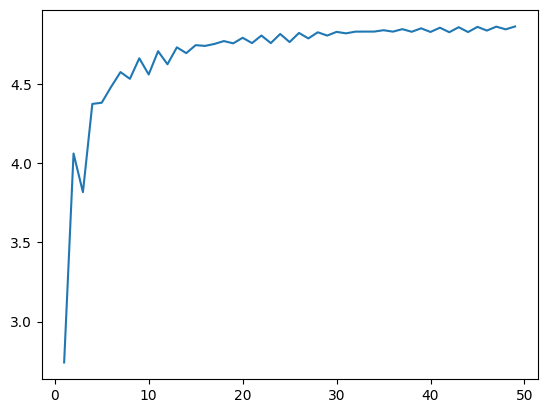

In [66]:
# Option params
sigma = 0.1
S = 80
T = 1.0
N = np.arange(1, 50)  # Play around with different ranges of N and step sizes (1,300)
K = 85
r = 0.1

# Calculate the option price for the correct parameters
optionPriceAnalytical = 0 # TODO

# calculate option price for each n in N
priceApproximatedly = []
for n in N:
    treeN = buildTree(S, sigma, T, n)
    priceApproximatedly.append(valueOptionMatrix(treeN, T, r, K, sigma)[0,0])

# use matplotlib to plot the analytical value
# and the approximated value for each n
plt.plot(N, [y-optionPriceAnalytical for y in priceApproximatedly])